In [1]:
# Imports
import os

# Data science and vis tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Nilearn: Python module for statistical processing of neuroimaging data.
from nilearn import datasets, plotting, image, interfaces

# NiftiMasker is for single regoin of interest
# NiftiMapsMasker is for probablistic atlas
# NiftiLabelsMasker is for discrete atlas
from nilearn.maskers import NiftiMasker, NiftiMapsMasker, NiftiLabelsMasker 

import nibabel as nib # Read and write access to common neuroimaging file formats
import nitime as nit # library for the analysis of time series in the field of neuroimaging. 

#Sklearn
from sklearn.decomposition import FastICA

# Custom python files
import component_plotting as cp

## Import Atlas

What is melodic FSL?

Melodic is the tool in FSL that we use at both the subject and group level to decompose FMRI data into time-courses and spatial maps using ICA. Dual regression is a tool that we can use as part of a group-level resting state analysis to identify the subject-specific contributions to the group level ICA.

MELODIC (Multivariate Exploratory Linear Optimized Decomposition into Independent Components) analysis. MELODIC is a tool used for independent component analysis (ICA) in functional magnetic resonance imaging (fMRI) data.

In [2]:
melodic_sum_file = os.path.abspath('../../Data/HCP/melodic_IC_sum.nii.gz') # Nifti 4D Data

Plots the different regions in the atlas

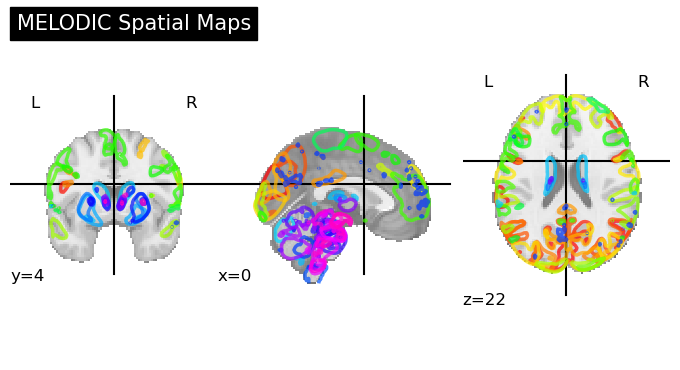

In [3]:
# Load Image
melodic_img = image.load_img(melodic_sum_file)

# Plot melodic spatial maps
plotting.plot_prob_atlas(melodic_img, title='MELODIC Spatial Maps')

### Andrew's Data

Get confounds and compute redisuals

In [4]:
andrew_file = os.path.abspath('../../Data/subject_Andrew/sub-00_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

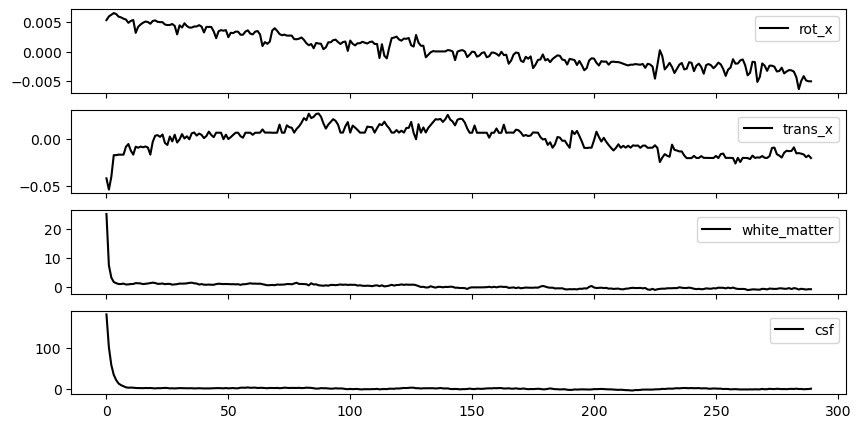

In [5]:
n_drop = 0

img = image.load_img(andrew_file) # Load my file

# get fMRIPrep calculated confounds
confounds = interfaces.fmriprep.load_confounds_strategy(andrew_file, denoise_strategy="simple")[0]

confounds.loc[n_drop:, ["rot_x", "trans_x", "white_matter", "csf"]].plot(
    kind="line", subplots=True, sharex=True, sharey=False, figsize=(10, 5), color="k"
)

In [6]:
masker = NiftiMapsMasker(
    maps_img=melodic_sum_file,
    smoothing_fwhm=6,  # gaussian kernel width (in mm)
    standardize="zscore_sample",  # zero mean, unit variance
    standardize_confounds="zscore_sample",
)

In [7]:
# residuals of OLS, drop first `n_drop` timepoints
time_series = masker.fit_transform(andrew_file, confounds=confounds)[n_drop:, :]
time_series.shape

(290, 100)

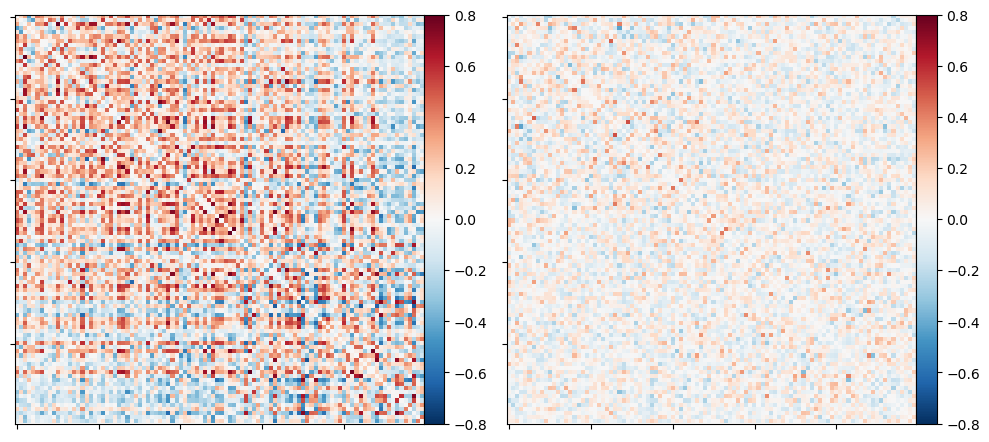

In [8]:
# pairwise correlations
X_corr = time_series.T @ time_series / (time_series.shape[0] - 1)

# partial correlations
# https://en.wikipedia.org/wiki/Partial_correlation#Using_matrix_inversion
X_inv = np.linalg.inv(X_corr)
X_pcorr = -X_inv / np.outer(np.sqrt(np.diag(X_inv)), np.sqrt(np.diag(X_inv)))

# Fill Diagonal to zero
np.fill_diagonal(X_corr, 0)
np.fill_diagonal(X_pcorr, 0)

# plot matrices
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
kwargs = dict(vmin=-0.8, vmax=0.8, colorbar=True)
plotting.plot_matrix(X_corr, axes=axs[0], **kwargs)
plotting.plot_matrix(X_pcorr, axes=axs[1], **kwargs) # Change so more readable

Positive Correlation


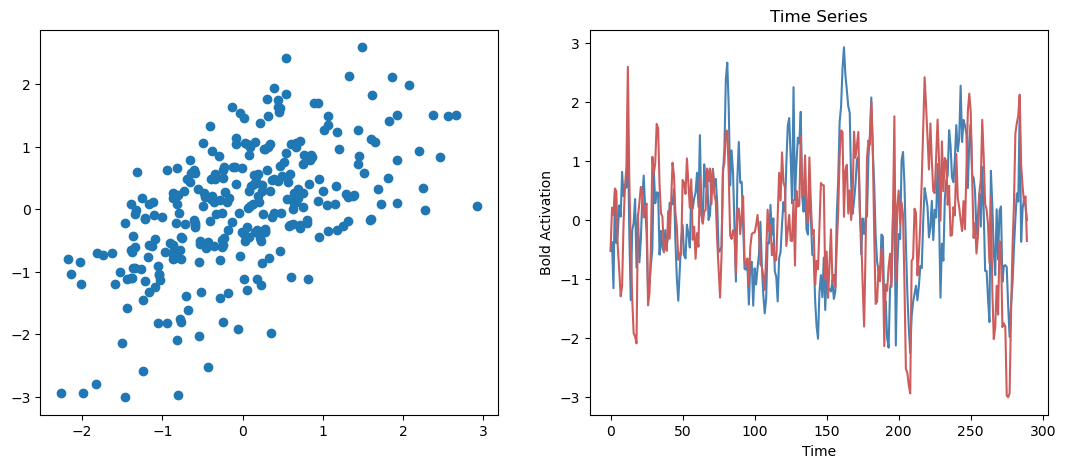

In [9]:
# Two correlated regions
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].scatter(time_series[:,2], time_series[:,12])

axes[1].plot(time_series[:,2], c = 'steelblue')
axes[1].plot(time_series[:,12], c = 'indianred')
axes[1].set(xlabel ='Time', ylabel = 'Bold Activation', title ='Time Series')

print('Positive Correlation')

**Fisher Transformation**

In [10]:
# Check if Valid
sum(np.isnan(np.arctanh(X_pcorr).flatten()))

0

In [11]:
X_pcorr_trans = np.arctanh(X_pcorr)
X_pcorr_trans[2]

array([ 0.0111835 ,  0.15349591,  0.        ,  0.32499202,  0.14836444,
       -0.0702563 ,  0.06465211,  0.41533526,  0.01903741, -0.04867984,
        0.28906791,  0.22350744,  0.12014799, -0.06651879, -0.23530856,
        0.12523496, -0.11012651, -0.11320954,  0.17285808,  0.10428762,
        0.01129839, -0.07233187, -0.00163654,  0.08651561,  0.1042558 ,
        0.13456525,  0.00992299,  0.42659009,  0.07804496,  0.12296766,
       -0.05935978,  0.22500214, -0.06591572, -0.03932712, -0.15653805,
        0.01890081, -0.17348551,  0.17689762,  0.0988987 ,  0.20416551,
        0.14419377, -0.22202819, -0.26976841,  0.00515828, -0.09264186,
       -0.28561419, -0.11241807, -0.1400089 , -0.02875294, -0.01508117,
       -0.10979447, -0.01055512,  0.02758087,  0.23415397,  0.05274674,
       -0.00987197,  0.15019497,  0.17259661, -0.02548313,  0.00179944,
       -0.0027416 ,  0.14223942, -0.098112  ,  0.25321309, -0.07677211,
       -0.10142518, -0.05269882,  0.04032999, -0.09709877, -0.10

In [12]:
# Norm of difference
np.linalg.norm(X_pcorr_trans - X_pcorr)

0.2378959490206484

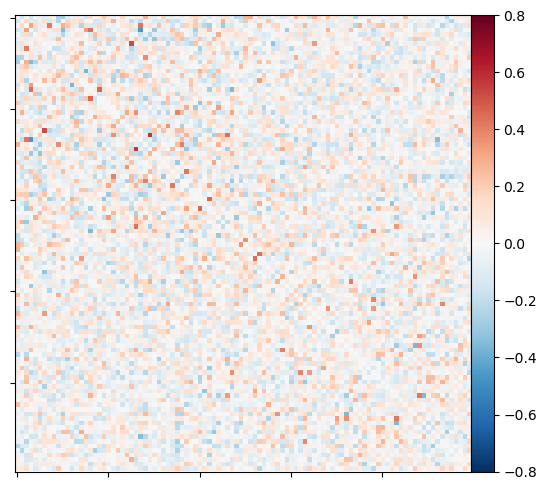

In [13]:
plotting.plot_matrix(X_pcorr_trans, **kwargs)

**Test with Knn Implementation**

In [14]:
%run KNN.ipynb

Accuracy with k=10 84.86055776892431
Accuracy with k=1 80.87649402390437
Accuracy with k=2 83.26693227091634
Accuracy with k=3 79.6812749003984
Accuracy with k=4 85.65737051792829
Accuracy with k=5 81.27490039840637
Accuracy with k=6 86.85258964143426
Accuracy with k=7 80.0796812749004
Accuracy with k=8 82.07171314741036
Accuracy with k=9 80.47808764940238
Accuracy with k=10 84.86055776892431
Accuracy with k=11 80.47808764940238
Accuracy with k=12 85.65737051792829
Accuracy with k=13 81.27490039840637
Accuracy with k=14 84.06374501992032
Accuracy with k=15 81.67330677290838
Accuracy with k=16 83.26693227091634
Accuracy with k=17 80.0796812749004
Accuracy with k=18 84.06374501992032
Accuracy with k=19 82.47011952191235
Accuracy with k=20 84.86055776892431
Accuracy with k=21 82.07171314741036
Accuracy with k=22 84.4621513944223
Accuracy with k=23 84.06374501992032
Accuracy with k=24 82.86852589641434


In [15]:
# Verify if my parents lied to me my whole life
knn10.predict([X_pcorr_trans.flatten()])

array(['M'], dtype='<U1')

In [16]:
distance, index = knn10.kneighbors([X_pcorr_trans.flatten()], 10)

In [17]:
index

array([[373, 435, 486, 147, 441, 571,  95, 487,  13, 129]])

In [18]:
data.iloc[index[0]]

,Gender,Age,netmat
subject_id,,,
182739,F,26-30,"[[0.0, -1.0802, 12.834, -12.359, -1.1353, 1.70..."
198855,M,26-30,"[[0.0, 0.90491, 13.742, -6.1279, -0.81053, 3.5..."
210415,F,26-30,"[[0.0, -1.4118, 15.353, -5.7759, 2.0992, 1.383..."
133625,M,26-30,"[[0.0, -0.95397, 17.837, -9.5529, 0.63421, 3.4..."
199958,M,31-35,"[[0.0, 0.22754, 5.3448, -8.1049, 1.4334, 3.609..."
305830,F,22-25,"[[0.0, -2.3737, 12.261, -8.9877, 0.21975, 1.45..."
121618,M,31-35,"[[0.0, -1.313, 14.403, -6.7715, 1.1183, 3.7387..."
210617,F,31-35,"[[0.0, -1.66, 6.0117, -5.1261, 0.74373, 3.8386..."
102715,M,26-30,"[[0.0, -0.87953, 9.0569, -6.9886, 2.7027, 2.17..."


**Plot the brain**

In [19]:
# Display my big brain (Mean Image)
mean_img = image.mean_img(andrew_file) # The mean of the Time Series Data

In [20]:
component_img = masker.inverse_transform(np.ones(100))

In [162]:
from matplotlib.ticker import ScalarFormatter

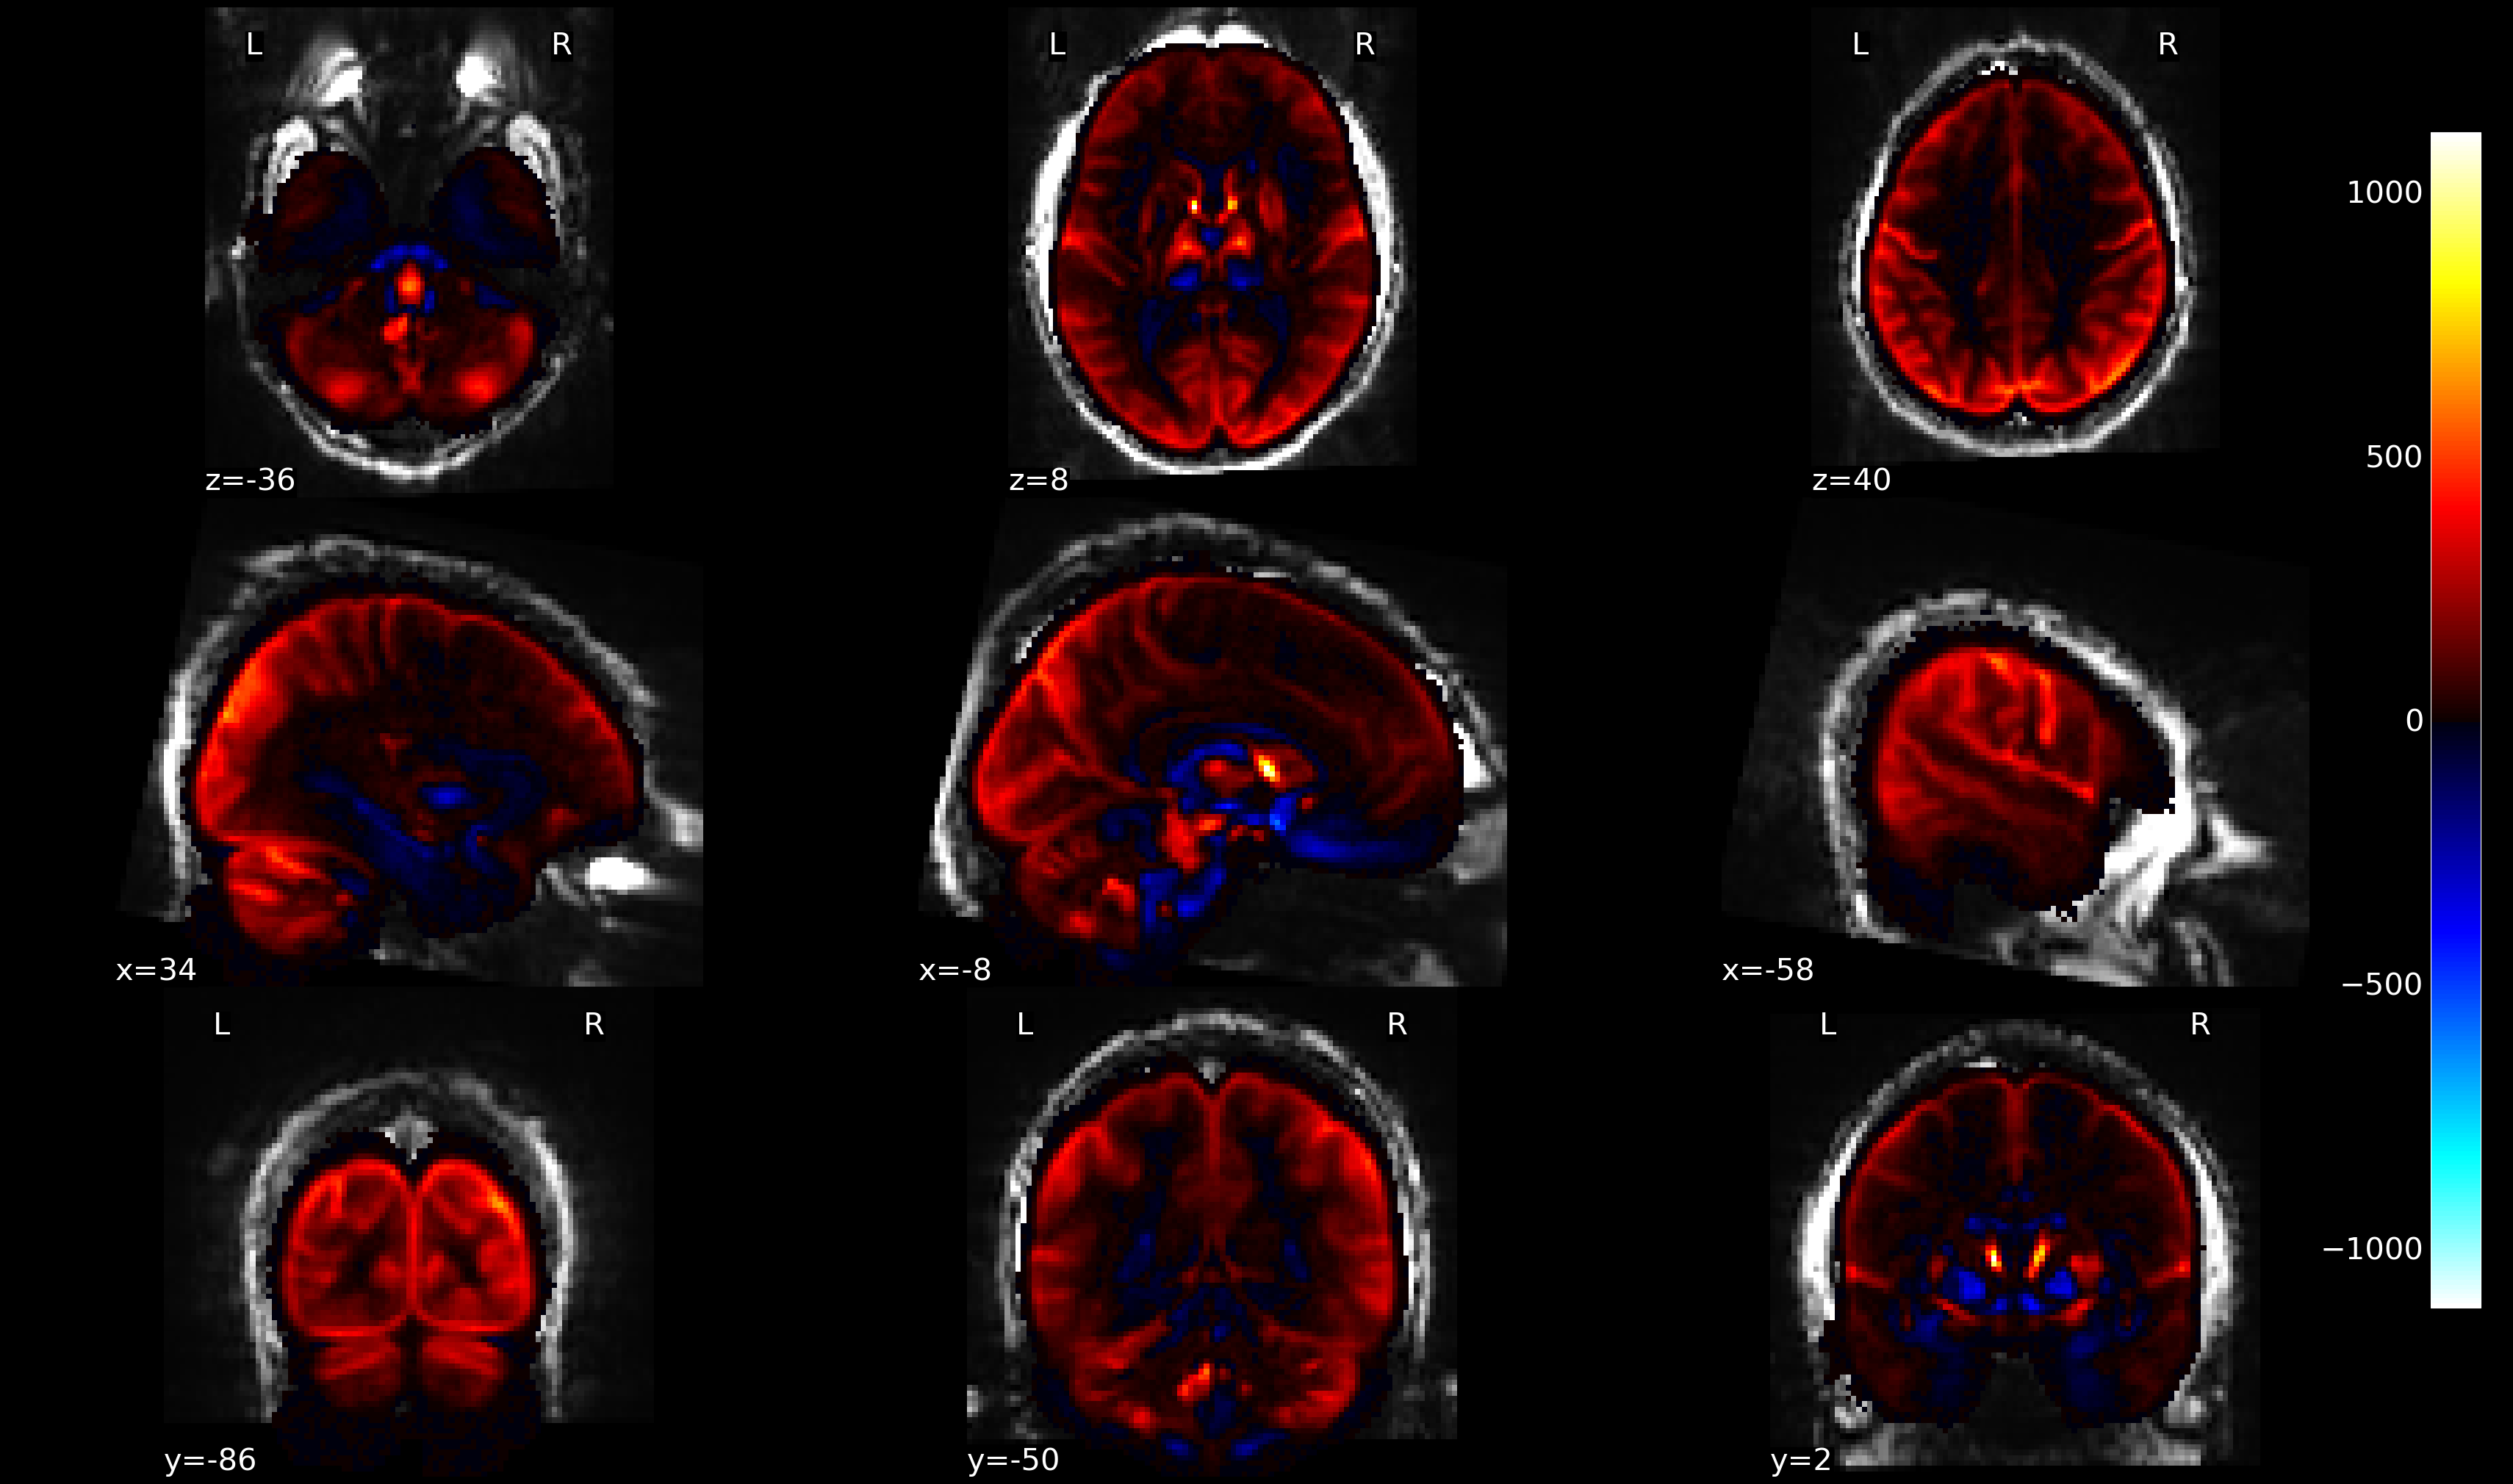

In [175]:
display = plotting.plot_stat_map(component_img, mean_img, display_mode = 'mosaic',
                       cut_coords = (3,3,3), dim = -1.4)

#display.title('MELODIC Spatial Maps of Andrew', size=30)
display.annotate(size=30)
display._colorbar_ax.tick_params(labelsize=30)
display._colorbar_ax.set_position([.97, .115, 0.02, 0.8])
display._cbar.set_ticks([-1000, -500, 0, 500, 1000])
display._cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))

plt.show()

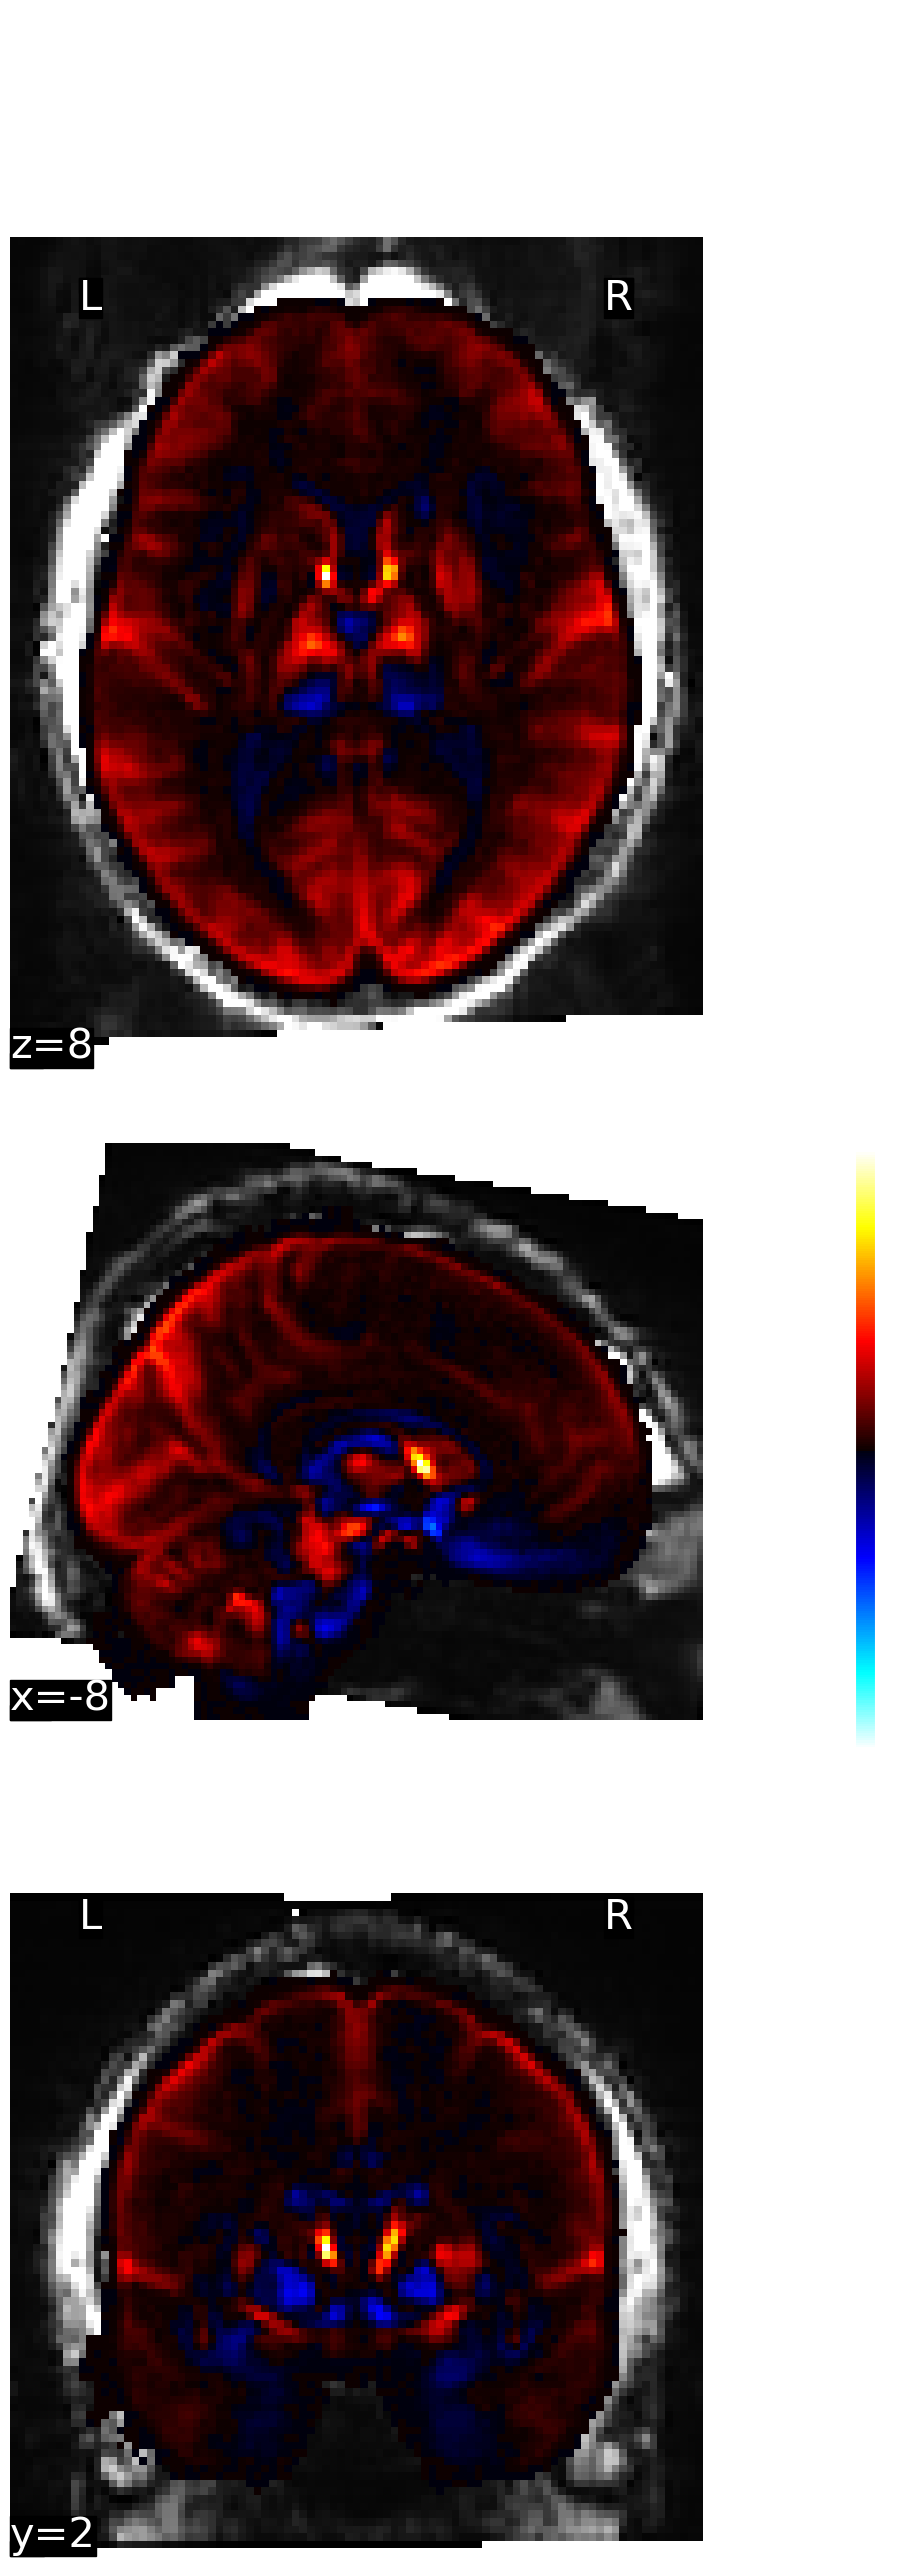

In [215]:
fig, ax = plt.subplots()

display = plotting.plot_stat_map(component_img, mean_img, display_mode = 'mosaic',draw_cross = False,
                       cut_coords = (1,1,1), dim = -1.4, axes = ax)

#display.title('MELODIC Spatial Maps of Andrew', size=30)
display.annotate(size=30)
display._colorbar_ax.tick_params(labelsize=30)
display._colorbar_ax.set_position([.97, .3, 0.02, 0.2])
display._cbar.set_ticks([-1000, -500, 0, 500, 1000])
display._cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))

plt.show()

**find default mode network**

In [22]:
# Using sklearn Fast ICA, we generate ICA components from time series

n = 3 # Number of components
seed = 42 # Seed for ICA

ica = FastICA(n_components = n, random_state = seed)
ica_components = ica.fit_transform(time_series.T).T

/Users/andrewcheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [23]:
# Centering and Standarding ICA components (As mentioned in methods section 2.2)
ica_components -= ica_components.mean(axis=0)
ica_components /= ica_components.std(axis=0)

In [24]:
ica_components.shape

(3, 100)

In [25]:
# First 3 components of our ICA
ica_first_comp, ica_second_comp, ica_third_comp = ica_components

print(ica_first_comp) #Example of first component

[ 1.34896674 -0.69517939 -0.05109934 -1.25356207  0.79382439 -0.52290944
 -1.33983369 -1.05580916 -0.34564558 -0.31967596  0.31863198 -0.45652288
  0.72511653 -1.3209184   0.83662393 -1.00070058  1.09570814 -1.30635114
 -0.68333043 -0.73445522  1.15931352 -0.00646674 -1.04528416 -0.44630087
 -0.83976336 -0.38736856  0.15117274  0.62393702  1.03101915 -0.27859537
 -1.30378853 -1.14958284 -0.855085   -1.41182465 -0.23945004  1.00104345
 -1.19936541 -0.79999584 -0.20913642 -1.17981582 -1.26124155  0.08285183
 -1.35044069  0.0291133   1.41419303 -1.06875577 -0.2099905  -0.78856131
  0.13212546  0.55415404  0.21517061 -1.33416159 -0.50506791 -1.19646057
 -1.24616565 -0.53658226  0.17875693 -0.82012149 -1.23312559  1.32802437
 -0.82173927 -1.41379577  1.40939584  0.13296729  1.3932647  -1.32848402
  1.0766106  -1.41343622  1.3492998   1.37719432 -0.92830391 -0.51808793
  1.18582883 -1.3306021   1.24068832  1.40155426  1.04698137  1.27244556
  1.01725041  0.75949209  1.37245678  0.81858461 -0

In [39]:
cp.get_component_masker(ica_second_comp, threshold = 1.4)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.41394999,  1.41385632,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.40995089,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -1.40388001,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.40783354,  0.        ,  0.        ,
        1.40764365,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

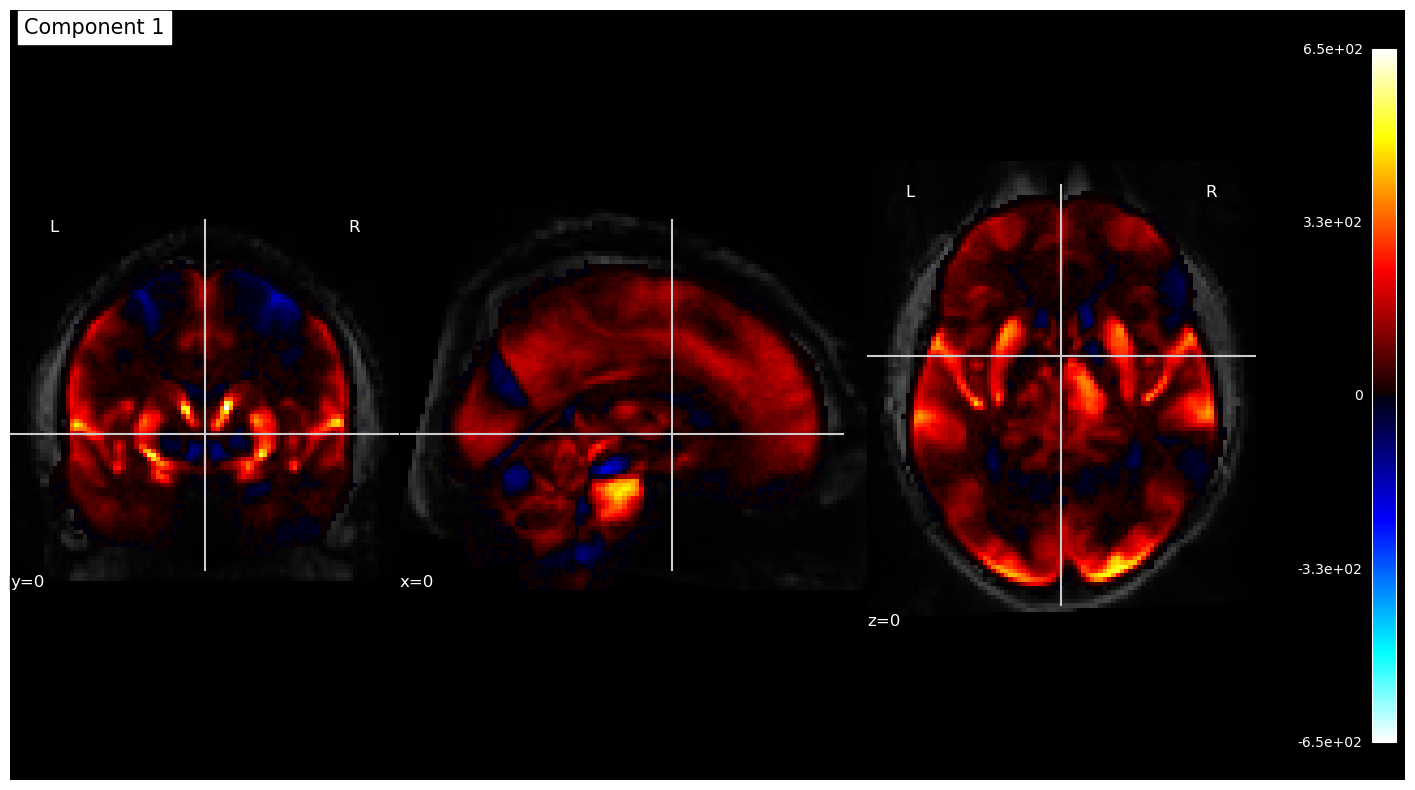

In [53]:
# Plot the scores of the first ICA component network
cp.plot_component(ica_first_comp, masker = masker, atlas = melodic_img, 
                  mean_img = mean_img, title = "Component 1", style = "score", 
                    threshold = 1.2, cut_coords = (0, 0, 0))

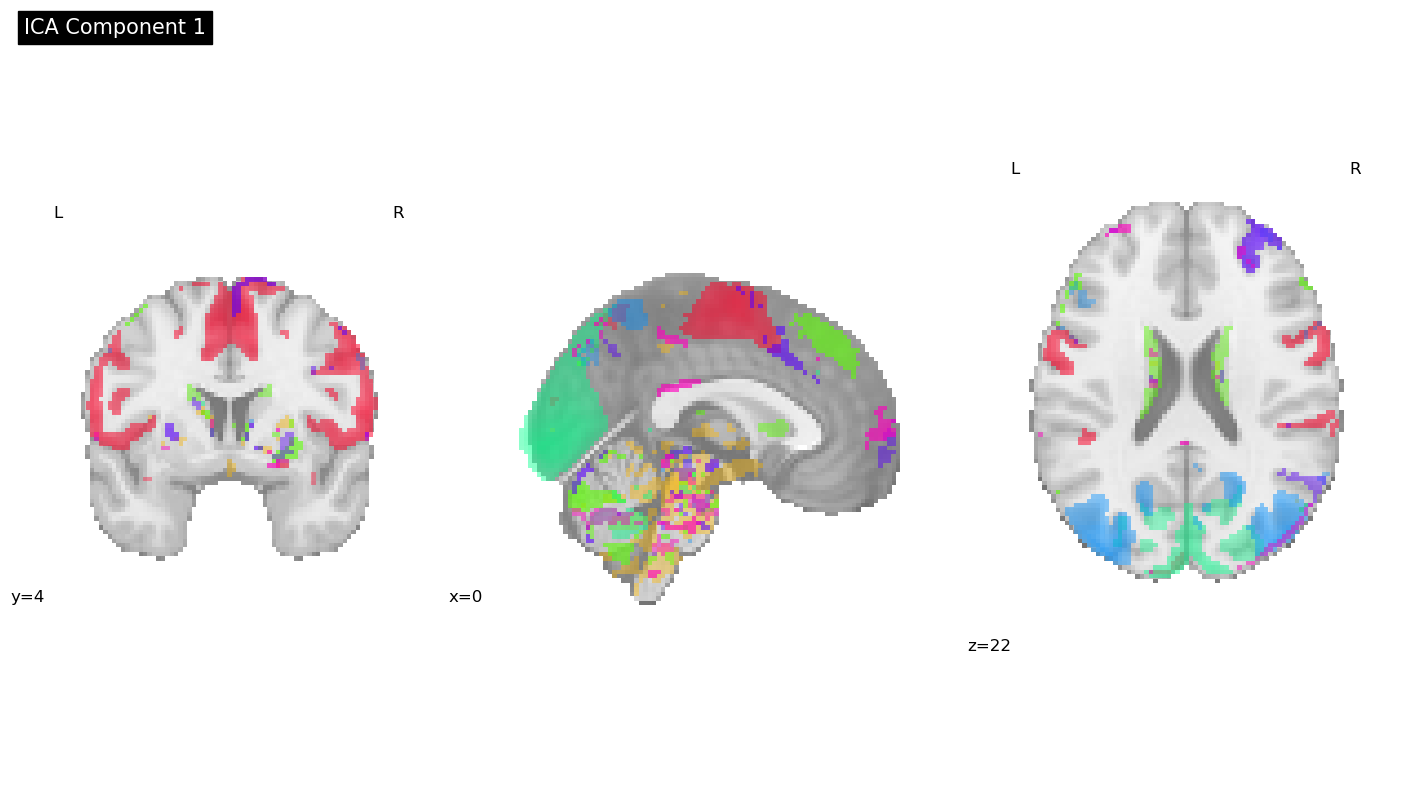

In [36]:
# Plot the regions of the first ICA component
cp.plot_component(ica_second_comp, masker = masker, atlas = melodic_img, title = "ICA Component 1", threshold = 1.4)